# Transfer learning 

**Transfer learning** is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

In computer vision this means that we can use many open sourced deep learning models which were trained on a huge amounts of images and took a lot of time to train. 

Tensorflow makes it very easy to use powerful CV models and tailor them to your specific problem. 

# Natural Image Classification

The dataset which we will be working with contains 6,899 images from 8 distinct classes compiled from various sources.

The classes include **airplane, car, cat, dog, flower, fruit, motorbike and person**. 

I obtained the data via: https://www.kaggle.com/prasunroy/natural-images 

# Reading the data

We will save the images in folders called training and validation.

In [1]:
import os 
# Defining a function for folder creation 
def create_dir(path) -> None:
    """
    Checks whether a directory exists and if not - creates it  
    """
    if not os.path.exists(path):
        os.mkdir(path)

In [2]:
import numpy as np
import random
import shutil

# Creating the training and validation folders
training_dir = f'{os.getcwd()}/natural_image_project/training'
validation_dir = f'{os.getcwd()}/natural_image_project/validation'

create_dir(training_dir)
create_dir(validation_dir)

# Defining the folder with all the raw images
raw_image_path = f'{os.getcwd()}/natural_image_project/natural_images'

# Defining the share of all images that will go to validation 
split = 0.1

# Getting all the class names
classes = os.listdir(raw_image_path)

for x in classes:
    # Creating the folders to store the images in
    create_dir(f'{training_dir}/{x}')
    create_dir(f'{validation_dir}/{x}')
    
    # Getting all the images in the dataset 
    all_img = os.listdir(f'{raw_image_path}/{x}')
    
    # Randomly shuffling data 
    all_img = random.sample(all_img, len(all_img))
    
    # Spliting into training and test sets
    index = int(len(all_img) * split)
    training = all_img[index:]
    test = all_img[:index]
    
    # Iterating through the training set 
    for img in training:
        if os.path.getsize(f'{raw_image_path}/{x}/{img}') > 0:
            shutil.copyfile(f'{raw_image_path}/{x}/{img}', f'{training_dir}/{x}/{img}')
            
    # Iterating through the test set 
    for img in test:
        if os.path.getsize(f'{raw_image_path}/{x}/{img}') > 0:
            shutil.copyfile(f'{raw_image_path}/{x}/{img}', f'{validation_dir}/{x}/{img}')              

Lets plot some random photos from each class.

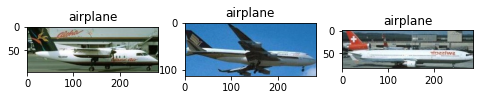

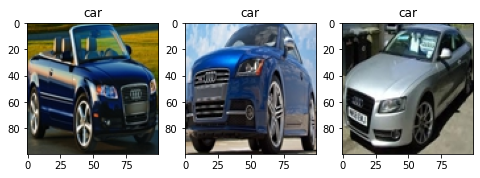

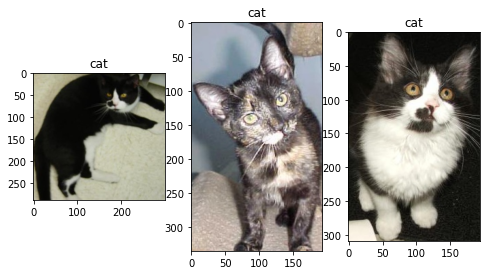

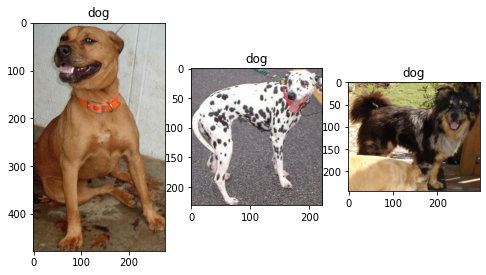

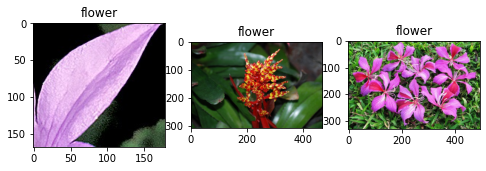

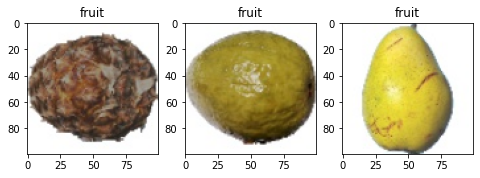

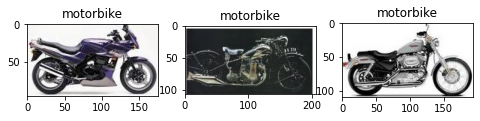

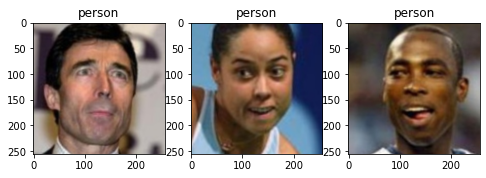

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for x in classes:
    # Getting all the images in the dataset 
    all_img = os.listdir(f'{training_dir}/{x}')
    
    # Random 3 photos
    img_to_plot = random.sample(all_img, 3)
    
    plt.figure(figsize=(8, 5))
    for i, img in enumerate(img_to_plot):
        plt.subplot(1, 3, i + 1)
        image = mpimg.imread(f'{training_dir}/{x}/{img}')
        plt.imshow(image)
        plt.title(f"{x}")
    plt.show()

## Loading the model

Usualy, the images in our projects are different in size when compared to the models which are already built in tensorflow. Very often, when loading the pretrained model, we should indicate the new input shape of the images and set the parameter include_top to False.

In [12]:
# The bellow code loads the model architecture
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Downloading the weights
# The include_top=False indicates that we will using our custom input layer
pretrained_model = InceptionV3(input_shape = (120, 120, 3), include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 377s 4us/step


In [13]:
# Number of layers
print(len(pretrained_model.layers))

311


The model is huge, containing 311 layers and millions of unique weights. 

One thing to note is that the input dimensions for the original model are 224x224x3. We override this by defining our own custom shape of 120x120x3.

The model outputs probabilities regarding 1000 classes. This will not be the case for our data thus we will freeze the top n layers of the model, add some custom layers at the bottom of the model and train it with our data.

In [14]:
# Make all the layers in the pre-trained model non-trainable
for layer in pretrained_model.layers:
    layer.trainable = False

# Transfering the learned part to our data

We first need to decide up to which to layer to freeze the trained network. You can do this by inspecting the model.summary() results and saving the name of the layer. 

Because the output is huge, I will not print it in this notebook but one good candidate is **'mixed7'**.

In [15]:
last_layer = pretrained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 5, 5, 768)


In [16]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with a ReLU activation
x = layers.Dense(256, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)               
# Add a final softmax layer for classification
x = layers.Dense(8, activation='softmax')(x)           

model = Model(pretrained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

And that is it! All the weights up to the defined neuron will be fixed and our new custom network will only learn the weights in the neurons at the bottom.

# Training and validating the model 

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(training_dir,
                                                    batch_size = 16,
                                                    class_mode = 'binary', 
                                                    target_size = (120, 120))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 16,
                                                          class_mode  = 'binary', 
                                                          target_size = (120, 120))

Found 6794 images belonging to 8 classes.
Found 1613 images belonging to 8 classes.


In [18]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            epochs = 3,
            verbose = 1)

Epoch 1/3
425/425 [==============================] - 365s 859ms/step - loss: 0.2647 - accuracy: 0.9268 - val_loss: 0.0976 - val_accuracy: 0.9820
Epoch 2/3
425/425 [==============================] - 363s 855ms/step - loss: 0.0861 - accuracy: 0.9720 - val_loss: 0.0658 - val_accuracy: 0.9888
Epoch 3/3
425/425 [==============================] - 365s 858ms/step - loss: 0.0712 - accuracy: 0.9790 - val_loss: 0.0564 - val_accuracy: 0.9882


# Visualizing the training

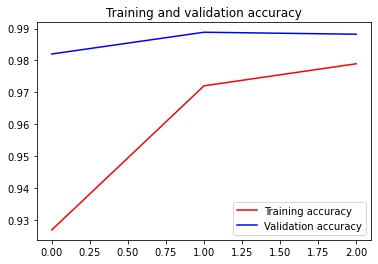

<Figure size 432x288 with 0 Axes>

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

Using the already trained model we managed to achieve a validation accuracy of 98%. We would not be able to achieve this using just 6794 photos for training and 8 very different classes. 